# Part 2C - NLP EDA of Amazon Reviews for Miracle Noodles (In-Depth)

In this notebook we will continue with the data we prepared in the last notebook.  
Our goals will be:
- compare sentiment analysis from VADER / TextBlob vs. the star rating.
- Apply LDA topic modeling to the reviews to idntify consistent themes. 
- Applied Named Entity Recognition to see if an NE's appear in certain types of reviws.

In [1]:
from IPython.display import display, Markdown
with open("data/Amazon Product Reviews.md") as f:
    info = f.read()

display(Markdown(info))

# Amazon Product Reviews

- URL: https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews 

## Description

This is a large crawl of product reviews from Amazon. This dataset contains 82.83 million unique reviews, from around 20 million users.

## Basic statistics

| Ratings:  | 82.83 million        |
| --------- | -------------------- |
| Users:    | 20.98 million        |
| Items:    | 9.35 million         |
| Timespan: | May 1996 - July 2014 |

## Metadata

- reviews and ratings
- item-to-item relationships (e.g. "people who bought X also bought Y")
- timestamps
- helpfulness votes
- product image (and CNN features)
- price
- category
- salesRank

## Example

```
{  "reviewerID": "A2SUAM1J3GNN3B",  "asin": "0000013714",  "reviewerName": "J. McDonald",  "helpful": [2, 3],  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",  "overall": 5.0,  "summary": "Heavenly Highway Hymns",  "unixReviewTime": 1252800000,  "reviewTime": "09 13, 2009" }
```

## Download link

See the [Amazon Dataset Page](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/) for download information.

The 2014 version of this dataset is [also available](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon/links.html).

## Citation

Please cite the following if you use the data:

**Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering**

R. He, J. McAuley

*WWW*, 2016
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/www16a.pdf)

**Image-based recommendations on styles and substitutes**

J. McAuley, C. Targett, J. Shi, A. van den Hengel

*SIGIR*, 2015
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir15.pdf)

# Part 2B - NLP EDA - Movie Reviews

In [2]:
# !pip install -U dojo_ds -q
import dojo_ds as ds
# ds.__version__

In [3]:
# !pip install missingno seaborn -q


In [4]:
import matplotlib.pyplot as plt
import missingno
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import os, json
from pprint import pprint
pd.set_option("display.max_columns",50)
# pd.set_option('display.max_colwidth', 250)

# fav_style = ('ggplot','tableau-colorblind10')
# fav_context  ={'context':'notebook', 'font_scale':1.1}
# plt.style.use(fav_style)
# sns.set_context(**fav_context)
# plt.rcParams['savefig.transparent'] = False
# plt.rcParams['savefig.bbox'] = 'tight'

In [5]:
FPATHS_FILE = "config/filepaths.json"

with open(FPATHS_FILE) as f:
    FPATHS = json.load(f)
FPATHS.keys()

dict_keys(['data', 'images', 'metadata', 'eda', 'models', 'results', 'readme'])

In [6]:
FPATHS['data'].keys()

dict_keys(['raw', 'cleaned', 'subset', 'processed-nlp', 'app', 'ml-nlp', 'nn-nlp'])

In [7]:
FPATHS['data']['processed-nlp']

{'processed-reviews-spacy_json': 'data/processed/processed-reviews.json',
 'processed-reviews-spacy_joblib': 'data/processed/processed-reviews.joblib',
 'processed-reviews-with-target_json': 'data/processed/processed-reviews-with-target.json',
 'processed-reviews-with-target_joblib': 'data/processed/processed-reviews-with-target.joblib'}

In [8]:
FPATHS['data']['ml-nlp']

{'train_joblib': 'data/modeling/training-data.joblib',
 'test_joblib': 'data/modeling/testing-data.joblib'}

In [9]:
# Fpath for saving final df with target columns
fpath_out_ml_with_targets = FPATHS['data']['processed-nlp']['processed-reviews-with-target_json']
fpath_out_ml_with_targets

'data/processed/processed-reviews-with-target.json'

In [10]:
## If using json
reviews_fpath = FPATHS['data']['processed-nlp']['processed-reviews-spacy_json']
reviews_fpath

'data/processed/processed-reviews.json'

In [11]:
df = pd.read_json(reviews_fpath)
# df = df.reset_index(drop=False)
df

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category,review-text-full,review-text-full_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined
0,B007JINB0W,A3Y51NV9HU5T2,"Great pasta taste and feel, but the spell in t...",Four Stars,4,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,"Four Stars: Great pasta taste and feel, but th...","Four Stars: Great pasta taste and feel, but th...","[four, stars, great, pasta, taste, and, feel, ...","[stars, great, pasta, taste, feel, spell, pack...","[star, great, pasta, taste, feel, spell, packa...",four stars great pasta taste and feel but the ...,stars great pasta taste feel spell packaged sk...,star great pasta taste feel spell package skrong
1,B007JINB0W,A3D7EFSRC6Y9MP,The texture just made it a little strange to e...,Okay but don't like texture,3,2014,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Okay but don't like texture: The texture just ...,Okay but don't like texture: The texture just ...,"[okay, but, do, n't, like, texture, the, textu...","[okay, like, texture, texture, little, strange...","[okay, like, texture, texture, little, strange...",okay but do n't like texture the texture just ...,okay like texture texture little strange eat f...,okay like texture texture little strange eat f...
2,B007JINB0W,A4AM5KBP3I2R,The herb flavor makes the odd texture of shira...,Go for the green noodles,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Go for the green noodles: The herb flavor make...,Go for the green noodles: The herb flavor make...,"[go, for, the, green, noodles, the, herb, flav...","[green, noodles, herb, flavor, makes, odd, tex...","[green, noodle, herb, flavor, make, odd, textu...",go for the green noodles the herb flavor makes...,green noodles herb flavor makes odd texture sh...,green noodle herb flavor make odd texture shir...
3,B007JINB0W,A3GHK4IL78DB7Y,I didn't have a problem at all with a half fil...,Its an awesome substitute.,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Its an awesome substitute.: I didn't have a pr...,Its an awesome substitute.: I didn't have a pr...,"[its, an, awesome, substitute, i, did, n't, ha...","[awesome, substitute, problem, half, filled, b...","[awesome, substitute, problem, half, fill, bag...",its an awesome substitute i did n't have a pro...,awesome substitute problem half filled bag use...,awesome substitute problem half fill bag user ...
4,B007JINB0W,AH3B94LQOPPY6,They taste like whatever you cook them with.,Five Stars,5,2016,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Five Stars: They taste like whatever you cook ...,Five Stars: They taste like whatever you cook ...,"[five, stars, they, taste, like, whatever, you...","[stars, taste, like, cook]","[star, taste, like, cook]",five stars they taste like whatever you cook t...,stars taste like cook,star taste like cook
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4358,B007JINB0W,A73IG1ED6S0JR,Product arrived with two of the bags punctured...,would not recomend,1,2016,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,would not recomend: Product arrived with two o...,would not recomend: Product arrived with two o...,"[would, not, recomend, product, arrived, with,...","[recomend, product, arrived, bags, punctured, ...","[recomend, product, arrive, bag, puncture, sme...",would not recomend product arrived with two of...,recomend product arrived bags punctured smells...,recomend product arrive bag puncture smell bad
4359,B007JINB0W,A1XZ2H0MYG54M0,Ok.,Five Stars,5,2016,"Miracle Noodle Zero Carb, Glute

In [12]:
# Check for duplciate review ids
dup_subset_cols = ['asin','reviewerID','review-text-full']
df.duplicated(subset=dup_subset_cols).sum()

0

In [13]:
# Check for duplicated review text
df.duplicated(subset=['review-text-full']).sum()

42

In [14]:
df.isna().sum()

asin                    0
reviewerID              0
reviewText              0
summary                 0
overall                 0
year                    0
title                   0
brand                   0
category                0
review-text-full        0
review-text-full_raw    0
tokens-dirty            0
tokens                  0
lemmas                  0
tokens-dirty-joined     0
tokens-joined           0
lemmas-joined           0
dtype: int64

<Axes: >

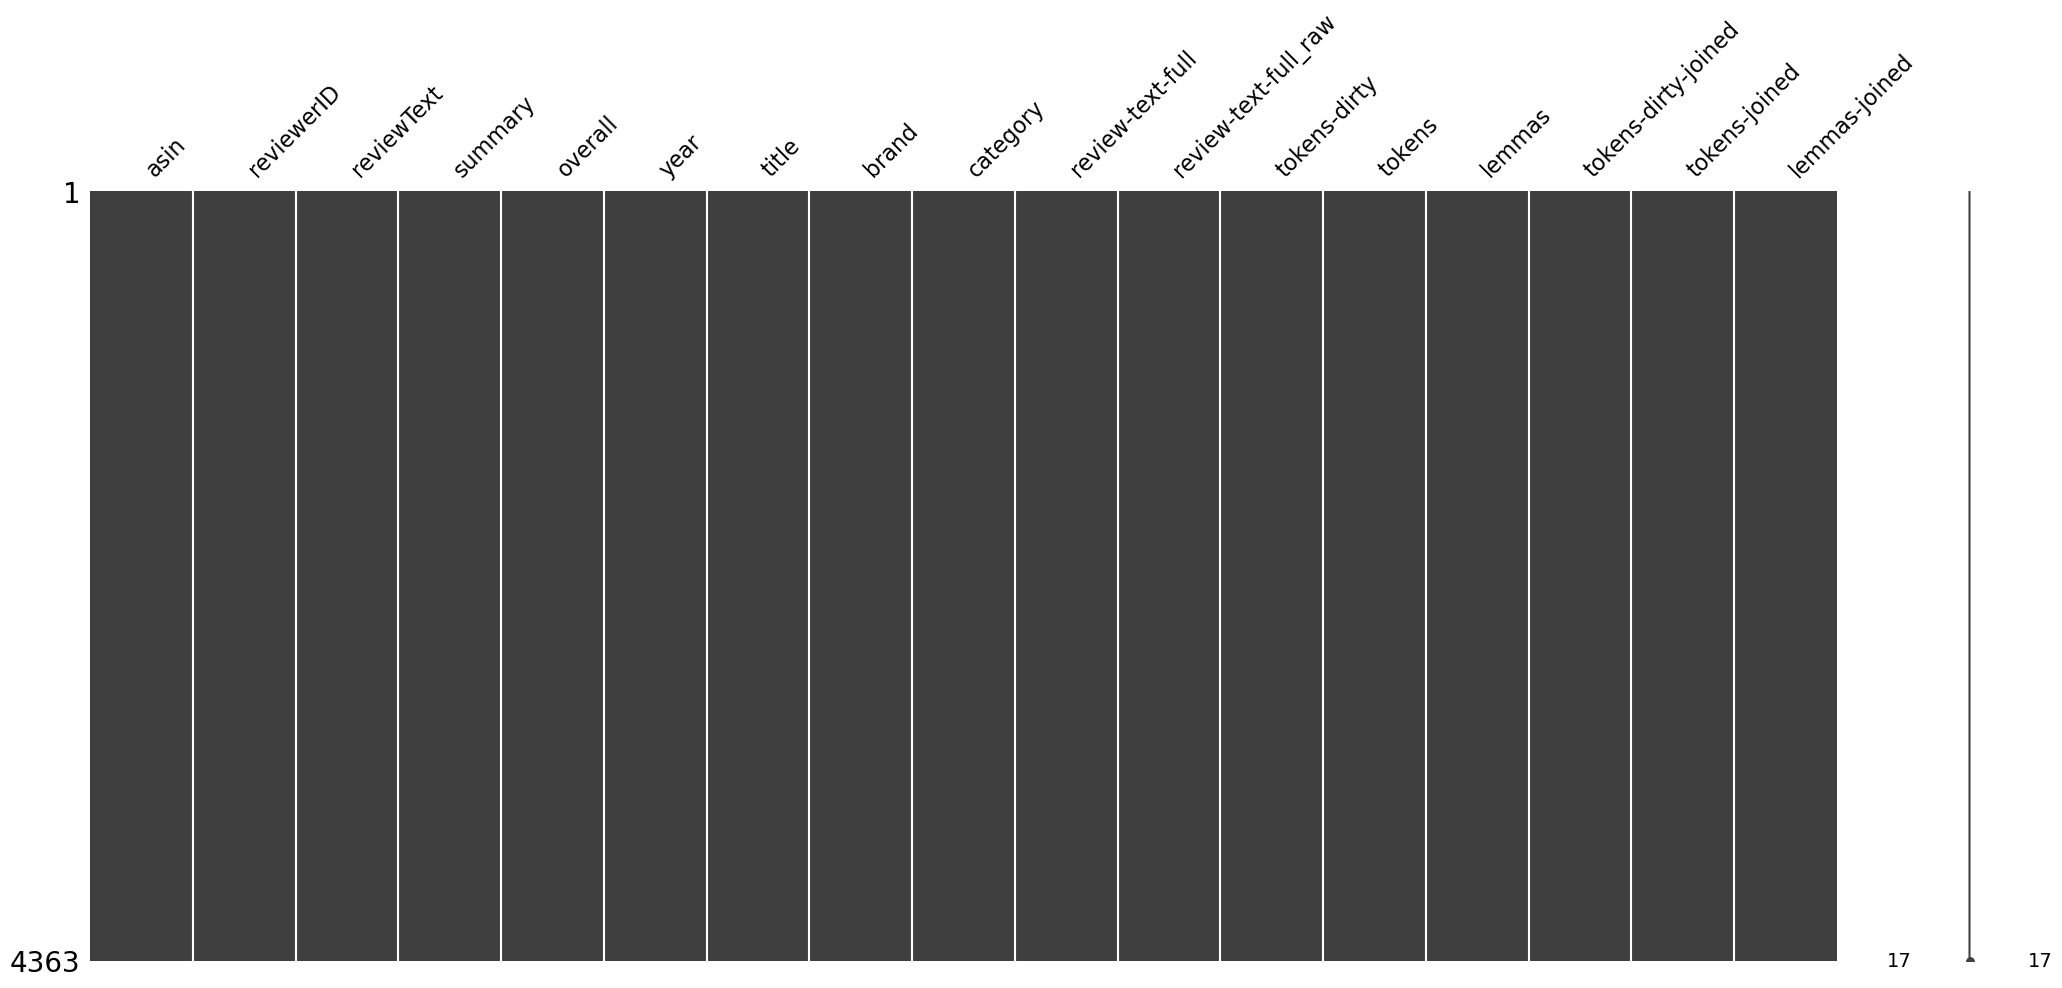

In [15]:
import missingno
missingno.matrix(df)

## Set Groups (for EDA & Modeling)

In [16]:
palette_tab10 = sns.palettes.color_palette('tab10',n_colors=len(df['overall'].unique()))
palette_tab10

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]

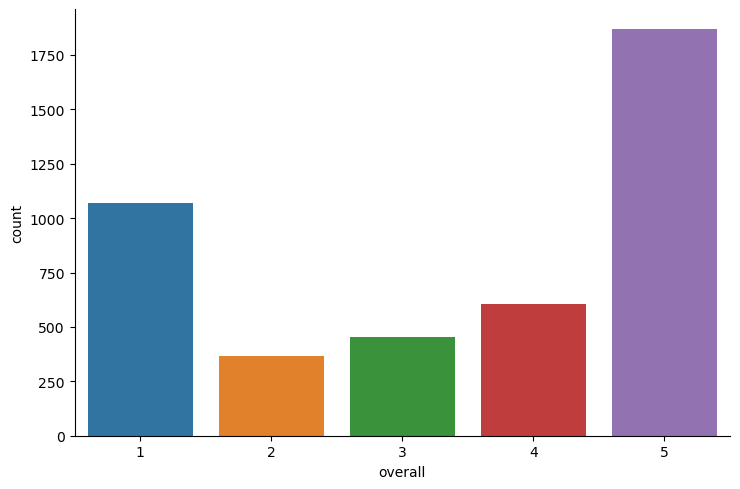

In [17]:
# ds.eda.explore_categorical(df,x='overall');
ax = sns.catplot(data=df,x='overall',kind='count', aspect=1.5, hue="overall",
            palette=palette_tab10,legend=False)

To understand what customers do and do not like about Hoover products, we will define 2 groups:
- High Ratings
    - Overall rating = 5.0
- Low Ratings
    - Overall rating = 1.0 or 2.0


We can use a function and .map to define group names based on the numeric overall ratings.

### Define Target Groups (02/08)

Binary:
- "High Rating": = 5
- "Low Rating": <= 2
<!-- 
Multiclass:
- "High Rating": >= 8
- "Mid Rating": 4< x < 8
- "Low Rating": <4 -->

In [18]:
def create_groups(x):
    if x>=5.0:
        return "High"
    elif x <=2.0:
        return "Low"
    else: 
        return None
    

# def set_groups_multi(x):
#     if x >= 8:
#         group = "High"
#     elif x>=4:
#         group = "Mid"
#     else:
#         group= "Low"
#     return group

In [19]:
df['target-rating'] = df['overall'].map(create_groups)#set_group_binary)
df['target-rating'].value_counts(dropna=False)

target-rating
High    1868
Low     1437
None    1058
Name: count, dtype: int64

### Class Balance

It's always a good idea to check the class balance when creating a classification model.  This can affect modeling bias and interpretation of metrics.

In [20]:
df['target-rating'].value_counts(dropna=True, normalize=True)

target-rating
High    0.565204
Low     0.434796
Name: proportion, dtype: float64

In [21]:
# fig, axes =  plt.subplots(ncols=2, figsize=(10,5))
# sns.histplot(data=df, x='overall', hue='target-rating', ax=axes[0])
# sns.histplot(data=df, x='target-rating', hue='target-rating', ax=axes[1], legend=False, stat='percent')
# fig.tight_layout()

#### Save Reviews with Target for Modeling (Part 3)

In [22]:
df.head(3)

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category,review-text-full,review-text-full_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined,target-rating
0,B007JINB0W,A3Y51NV9HU5T2,"Great pasta taste and feel, but the spell in t...",Four Stars,4,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,"Four Stars: Great pasta taste and feel, but th...","Four Stars: Great pasta taste and feel, but th...","[four, stars, great, pasta, taste, and, feel, ...","[stars, great, pasta, taste, feel, spell, pack...","[star, great, pasta, taste, feel, spell, packa...",four stars great pasta taste and feel but the ...,stars great pasta taste feel spell packaged sk...,star great pasta taste feel spell package skrong,None
1,B007JINB0W,A3D7EFSRC6Y9MP,The texture just made it a little strange to e...,Okay but don't like texture,3,2014,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Okay but don't like texture: The texture just ...,Okay but don't like texture: The texture just ...,"[okay, but, do, n't, like, texture, the, textu...","[okay, like, texture, texture, little, strange...","[okay, like, texture, texture, little, strange...",okay but do n't like texture the texture just ...,okay like texture texture little strange eat f...,okay like texture texture little strange eat f...,None
2,B007JINB0W,A4AM5KBP3I2R,The herb flavor makes the odd texture of shira...,Go for the green noodles,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Go for the green noodles: The herb flavor make...,Go for the green noodles: The herb flavor make...,"[go, for, the, green, noodles, the, herb, flav...","[green, noodles, herb, flavor, makes, odd, tex...","[green, noodle, herb, flavor, make, odd, textu...",go for the green noodles the herb flavor makes...,green noodles herb flavor makes odd texture sh...,green noodle herb flavor make odd texture shir...,High


In [23]:
# Save the df with target columns
fpath_out_ml_with_targets =  FPATHS['data']['processed-nlp']['processed-reviews-with-target_json']
fpath_out_ml_with_targets

'data/processed/processed-reviews-with-target.json'

In [24]:
FPATHS['data']['processed-nlp']

{'processed-reviews-spacy_json': 'data/processed/processed-reviews.json',
 'processed-reviews-spacy_joblib': 'data/processed/processed-reviews.joblib',
 'processed-reviews-with-target_json': 'data/processed/processed-reviews-with-target.json',
 'processed-reviews-with-target_joblib': 'data/processed/processed-reviews-with-target.joblib'}

In [25]:
# Save to json
df.to_json(fpath_out_ml_with_targets)

In [26]:
# Test saved json file
pd.read_json(fpath_out_ml_with_targets)

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category,review-text-full,review-text-full_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined,target-rating
0,B007JINB0W,A3Y51NV9HU5T2,"Great pasta taste and feel, but the spell in t...",Four Stars,4,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,"Four Stars: Great pasta taste and feel, but th...","Four Stars: Great pasta taste and feel, but th...","[four, stars, great, pasta, taste, and, feel, ...","[stars, great, pasta, taste, feel, spell, pack...","[star, great, pasta, taste, feel, spell, packa...",four stars great pasta taste and feel but the ...,stars great pasta taste feel spell packaged sk...,star great pasta taste feel spell package skrong,None
1,B007JINB0W,A3D7EFSRC6Y9MP,The texture just made it a little strange to e...,Okay but don't like texture,3,2014,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Okay but don't like texture: The texture just ...,Okay but don't like texture: The texture just ...,"[okay, but, do, n't, like, texture, the, textu...","[okay, like, texture, texture, little, strange...","[okay, like, texture, texture, little, strange...",okay but do n't like texture the texture just ...,okay like texture texture little strange eat f...,okay like texture texture little strange eat f...,None
2,B007JINB0W,A4AM5KBP3I2R,The herb flavor makes the odd texture of shira...,Go for the green noodles,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Go for the green noodles: The herb flavor make...,Go for the green noodles: The herb flavor make...,"[go, for, the, green, noodles, the, herb, flav...","[green, noodles, herb, flavor, makes, odd, tex...","[green, noodle, herb, flavor, make, odd, textu...",go for the green noodles the herb flavor makes...,green noodles herb flavor makes odd texture sh...,green noodle herb flavor make odd texture shir...,High
3,B007JINB0W,A3GHK4IL78DB7Y,I didn't have a problem at all with a half fil...,Its an awesome substitute.,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Its an awesome substitute.: I didn't have a pr...,Its an awesome substitute.: I didn't have a pr...,"[its, an, awesome, substitute, i, did, n't, ha...","[awesome, substitute, problem, half, filled, b...","[awesome, substitute, problem, half, fill, bag...",its an awesome substitute i did n't have a pro...,awesome substitute problem half filled bag use...,awesome substitute problem half fill bag user ...,High
4,B007JINB0W,AH3B94LQOPPY6,They taste like whatever you cook them with.,Five Stars,5,2016,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Five Stars: They taste like whatever you cook ...,Five Stars: They taste like whatever you cook ...,"[five, stars, they, taste, like, whatever, you...","[stars, taste, like, cook]","[star, taste, like, cook]",five stars they taste like whatever you cook t...,stars taste like cook,star taste like cook,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4358,B007JINB0W,A73IG1ED6S0JR,Product arrived with two of the bags punctured...,would not recomend,1,2016,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,would not recomend: Product arrived with two o...,would not recomend: Product arrived with two o...,"[would, not, recomend, product, arrived, with,...","[recomend, product, arrived, bags, punctured, ...","[recomend, product, arrive, bag, puncture, sme...",would not recomend product arrived with two of...,recomend product arrived bags punctured smells...,recomend product arrive bag puncture smell bad,Low
4359,B007JINB0W,A1XZ2H0MYG54M0,Ok.,Fiv

In [27]:
FPATHS['data']['processed-nlp']['processed-reviews-with-target_joblib']

'data/processed/processed-reviews-with-target.joblib'

In [28]:
import joblib
joblib.dump(df, FPATHS['data']['processed-nlp']['processed-reviews-with-target_joblib'],compress=9)

['data/processed/processed-reviews-with-target.joblib']

In [29]:
# Saving MVP test case 
mvp_cols = ['reviewerID','review-text-full',
            'overall',
            'target-rating']
df[mvp_cols]

,reviewerID,review-text-full,overall,target-rating
0,A3Y51NV9HU5T2,"Four Stars: Great pasta taste and feel, but th...",4,None
1,A3D7EFSRC6Y9MP,Okay but don't like texture: The texture just ...,3,None
2,A4AM5KBP3I2R,Go for the green noodles: The herb flavor make...,5,High
3,A3GHK4IL78DB7Y,Its an awesome substitute.: I didn't have a pr...,5,High
4,AH3B94LQOPPY6,Five Stars: They taste like whatever you cook ...,5,High
...,...,...,...,...
4358,A73IG1ED6S0JR,would not recomend: Product arrived with two o...,1,Low
4359,A1XZ2H0MYG54M0,Five Stars: Ok.,5,High
4360,A3I2YF0MXB7P0B,"Not awful, but now I know why these were on sa...",2,Low
4361,A2UELLFLITPMT1,Don't even try it.: Truly horrific. Like eatin...,1,Low


In [30]:
fpath_llm = FPATHS['data']['app']['reviews-with-target-for-llm_csv']
df[mvp_cols].to_csv(fpath_llm, index=False)

# Part 2) EDA and Visualization

**2) EDA and Visualization:**

- Create word clouds to visualize the most frequent and significant words in each group.
    - Remember, you can use this analysis to identify additional custom EDA stop words to use for visualization. (e.g., if the words are common in both groups)
    - **Save your wordclouds as .png files in the "Images/" folder in your repo.**



- Apply nltk's `FreqDist` class to compare the frequency distribution of words in the review groups.
    - Remember, you can use this analysis to identify additional custom EDA stop words to use for visualization. (e.g., if the words are common in both groups)
    - **Save your freq dist plots as .png files in the "Images/" folder in your repo.**



- Perform n-grams analysis (bigrams and trigrams),
    - Remember, you can use this analysis to identify additional custom stop words to use for EDA. (e.g., if the words are common in both groups)
    - Focus on bigrams or trigrams, using NLTK's `BigramCollocationFinder` and BigramAssocMeasures classes (or the Trigram equivalent Finder and Measures) to explore commonly used groups of words for each rating-group.
    - Describe any differences. What do these differences tell you?
    - `Save your...`?



- Perform sentiment analysis to create polarity scores according to VADERS's sentiment lexicon.

    - Compare the sentiments of high-rating and low-rating texts.

    - Compare the average sentiment scores for high and low-rating reviews.

    - Which review polarity scores don't match the ratings? Why do you think this is?

        

**3) Evaluation and Reporting:**

- Based on your analyses, what should someone do (or not do) if they want to make a highly-rated movie?
    - List 3 things associated with high-rating reviews
    - List 3 things associated with low-rating reviews.

> Adding imports as-if standalone notebook

In [31]:
import matplotlib.pyplot as plt
import missingno
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd

import spacy
# nlp_custom = fn.nlp.make_custom_nlp(disable=['ner','parser'],contractions=[],
#                             stopwords_to_add=["★"])
# nlp_custom
# # Disable parser and ner
# # nlp_light = spacy.load("en_core_web_sm", disable=['parser','ner'])

## Topic Analysis

In [32]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser','ner'])
nlp

In [33]:
df['review-text-full'].head(3)

0    Four Stars: Great pasta taste and feel, but th...
1    Okay but don't like texture: The texture just ...
2    Go for the green noodles: The herb flavor make...
Name: review-text-full, dtype: object

In [34]:
spacy.tokens.Doc

spacy.tokens.doc.Doc

In [35]:
def preprocess(text):
    if isinstance(text, spacy.tokens.Doc)==False:
        doc = nlp(text)
    else:
        doc = text
    result = [token.lemma_ for token in doc if not token.is_stop and len(token) > 3]
    return result

In [36]:
lemmas = []
for doc in  nlp.pipe(df['review-text-full'], batch_size=100, n_process=-1):
    lemmas.append(preprocess(doc))

In [37]:
print(f"{len(lemmas)=}, {len(df['review-text-full'])=}")
lemmas[:10]

len(lemmas)=4363, len(df['review-text-full'])=4363


[['star', 'great', 'pasta', 'taste', 'feel', 'spell', 'package', 'SKRONG'],
 ['okay',
  'like',
  'texture',
  'texture',
  'little',
  'strange',
  'flavor',
  'okay',
  'bland',
  'spice'],
 ['green',
  'noodle',
  'herb',
  'flavor',
  'make',
  'texture',
  'shirataki',
  'palatable'],
 ['awesome',
  'substitute',
  'problem',
  'half',
  'fill',
  'user',
  'say',
  'concern',
  'take',
  'chance',
  'problem',
  'find',
  'good',
  'initial',
  'smell',
  'boil',
  'cube',
  'bouillon',
  'texture',
  'good',
  'notice',
  'replace',
  'noodle',
  'mind'],
 ['star', 'taste', 'like', 'cook'],
 ['love',
  'come',
  'italian',
  'girl',
  'resist',
  'pasta',
  'dish',
  'savior',
  'avoid',
  'carb',
  'want',
  'tasty',
  'meal',
  'smell',
  'little',
  'funky',
  'open',
  'package',
  'go',
  'away',
  'rince',
  'water',
  'miss',
  'regular',
  'pasta',
  'anymore',
  'love'],
 ['taste',
  'okay',
  'taste',
  'okay',
  'expect',
  'zero',
  'calorie',
  'lunch',
  'day',
  '

In [38]:
df['lemmas'] = lemmas
df.head(2)

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category,review-text-full,review-text-full_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined,target-rating
0,B007JINB0W,A3Y51NV9HU5T2,"Great pasta taste and feel, but the spell in t...",Four Stars,4,2018,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,"Four Stars: Great pasta taste and feel, but th...","Four Stars: Great pasta taste and feel, but th...","[four, stars, great, pasta, taste, and, feel, ...","[stars, great, pasta, taste, feel, spell, pack...","[star, great, pasta, taste, feel, spell, packa...",four stars great pasta taste and feel but the ...,stars great pasta taste feel spell packaged sk...,star great pasta taste feel spell package skrong,None
1,B007JINB0W,A3D7EFSRC6Y9MP,The texture just made it a little strange to e...,Okay but don't like texture,3,2014,"Miracle Noodle Zero Carb, Gluten Free Shiratak...",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodl...,Okay but don't like texture: The texture just ...,Okay but don't like texture: The texture just ...,"[okay, but, do, n't, like, texture, the, textu...","[okay, like, texture, texture, little, strange...","[okay, like, texture, texture, little, strange...",okay but do n't like texture the texture just ...,okay like texture texture little strange eat f...,okay like texture texture little strange eat f...,None


## @ChatGPT Here:

### Step 3: Prepare the data for LDA


> Needed to install `pip install scipy==1.10.1` due to triu missing from scipy error.


In [39]:
import gensim
import  scipy
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim import corpora


print(f"{gensim.__version__=}, {scipy.__version__=}")

gensim.__version__='4.3.2', scipy.__version__='1.10.1'


In [40]:

# Separate group
high_reviews = df.loc[df['target-rating']=='High','lemmas']
low_reviews = df.loc[df['target-rating']=='Low','lemmas']

# Create dictionary and corpus for high-rating reviews
high_dictionary = corpora.Dictionary(high_reviews)
high_corpus = [high_dictionary.doc2bow(text) for text in high_reviews]

# Create dictionary and corpus for low-rating reviews
low_dictionary = corpora.Dictionary(low_reviews)
low_corpus = [low_dictionary.doc2bow(text) for text in low_reviews]


In [41]:
# Number of topics
num_topics = 5

# LDA model for high-rating reviews
high_lda = LdaModel(high_corpus, num_topics=num_topics, id2word=high_dictionary, passes=15)

# LDA model for low-rating reviews
low_lda = LdaModel(low_corpus, num_topics=num_topics, id2word=low_dictionary, passes=15)

In [42]:
# Print the topics for high-rating reviews
print("High Rating Reviews Topics:")
for idx, topic in high_lda.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}")

# Print the topics for low-rating reviews
print("Low Rating Reviews Topics:")
for idx, topic in low_lda.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}")

High Rating Reviews Topics:
Topic: 0 
Words: 0.037*"noodle" + 0.022*"like" + 0.018*"smell" + 0.016*"taste" + 0.014*"follow" + 0.014*"rinse" + 0.014*"rice" + 0.013*"great" + 0.013*"carb" + 0.012*"good"
Topic: 1 
Words: 0.044*"star" + 0.041*"love" + 0.037*"great" + 0.034*"carb" + 0.031*"noodle" + 0.029*"rice" + 0.028*"pasta" + 0.024*"good" + 0.020*"taste" + 0.017*"product"
Topic: 2 
Words: 0.021*"sauce" + 0.018*"love" + 0.016*"noodle" + 0.012*"pasta" + 0.011*"review" + 0.010*"follow" + 0.010*"taste" + 0.008*"Noodles" + 0.008*"good" + 0.007*"cook"
Topic: 3 
Words: 0.045*"pasta" + 0.027*"noodle" + 0.020*"great" + 0.018*"like" + 0.017*"carb" + 0.017*"product" + 0.016*"sauce" + 0.015*"good" + 0.010*"dish" + 0.010*"calorie"
Topic: 4 
Words: 0.050*"noodle" + 0.021*"like" + 0.020*"rinse" + 0.018*"sauce" + 0.016*"smell" + 0.015*"water" + 0.012*"minute" + 0.012*"good" + 0.012*"taste" + 0.012*"great"
Low Rating Reviews Topics:
Topic: 0 
Words: 0.040*"like" + 0.038*"noodle" + 0.026*"smell" + 0.022*

In [43]:
# !pip install tabulate

In [44]:
from tabulate import tabulate

def print_topics_table(lda_model, num_topics, orientation="rows", print_output=True):
    topics_words = lda_model.print_topics(num_topics=num_topics)

    if orientation == "rows":
        table_data = []
        for idx, topic in topics_words:
            words = topic.split(" + ")
            words = ["{} ({})".format(word.split('*')[1].replace('"', ''), word.split('*')[0]) for word in words]
            table_data.append(["Topic {}".format(idx + 1)] + words)

        # Ensure all rows have the same number of columns
        max_words = max(len(topic) for topic in table_data)
        for topic in table_data:
            while len(topic) < max_words:
                topic.append("")  # Fill shorter rows with empty strings

        headers = ["Topic"] + ["Word {}".format(i + 1) for i in range(max_words - 1)]

    elif orientation == "columns":
        table_data = [[] for _ in range(num_topics)]
        for idx, topic in topics_words:
            words = topic.split(" + ")
            words = ["{} ({})".format(word.split('*')[1].replace('"', ''), word.split('*')[0]) for word in words]
            table_data[idx].extend(words)

        # Transpose the data to have topics as columns
        max_words = max(len(topic) for topic in table_data)
        for topic in table_data:
            while len(topic) < max_words:
                topic.append("")  # Fill shorter topics with empty strings

        table_data = list(map(list, zip(*table_data)))
        headers = ["Topic {}".format(i + 1) for i in range(num_topics)]

    else:
        raise ValueError("Invalid orientation. Choose 'rows' or 'columns'.")

    table = tabulate(table_data, headers=headers, tablefmt="pretty")

    if print_output:
        print(table)
    else:
        return table

# Print the topics for high-rating reviews as rows
print("High Rating Reviews Topics (Rows):")
print_topics_table(high_lda, num_topics, orientation="rows")

# Print the topics for low-rating reviews as columns
print("Low Rating Reviews Topics (Columns):")
print_topics_table(low_lda, num_topics, orientation="rows")


High Rating Reviews Topics (Rows):
+---------+----------------+----------------+----------------+---------------+----------------+-----------------+----------------+-----------------+---------------+-----------------+
|  Topic  |     Word 1     |     Word 2     |     Word 3     |    Word 4     |     Word 5     |     Word 6      |     Word 7     |     Word 8      |    Word 9     |     Word 10     |
+---------+----------------+----------------+----------------+---------------+----------------+-----------------+----------------+-----------------+---------------+-----------------+
| Topic 1 | noodle (0.037) |  like (0.022)  | smell (0.018)  | taste (0.016) | follow (0.014) |  rinse (0.014)  |  rice (0.014)  |  great (0.013)  | carb (0.013)  |  good (0.012)   |
| Topic 2 |  star (0.044)  |  love (0.041)  | great (0.037)  | carb (0.034)  | noodle (0.031) |  rice (0.029)   | pasta (0.028)  |  good (0.024)   | taste (0.020) | product (0.017) |
| Topic 3 | sauce (0.021)  |  love (0.018)  | nood



#### Explanation:

1. **Define Function with `orientation` kwarg**:
   - The function `print_topics_table` accepts an additional keyword argument `orientation` which can be either `"rows"` or `"columns"`, and a boolean `print_output` to control whether to print or return the table.

2. **Handle Rows Orientation**:
   - If `orientation` is `"rows"`, the function processes the topics to have each topic as a row with words as columns.
   - Ensures all rows have the same number of columns by filling shorter rows with empty strings.
   - Defines headers accordingly and uses `tabulate` to format the table.

3. **Handle Columns Orientation**:
   - If `orientation` is `"columns"`, the function processes the topics to have each topic as a column with words as rows.
   - Ensures all topics (columns) have the same number of rows by filling shorter columns with empty strings.
   - Transposes the data to have topics as columns.
   - Defines headers accordingly and uses `tabulate` to format the table.

4. **Raise Error for Invalid Orientation**:
   - If an invalid orientation is provided, the function raises a `ValueError`.

5. **Print or Return Table**:
   - If `print_output` is `True`, the table is printed.
   - If `print_output` is `False`, the table is returned as a string.

This modification makes the function flexible, allowing you to choose the orientation of the topics table and control whether the output is printed or returned.

In [45]:

# def topics_to_dataframe(lda_model, num_topics, orientation="rows"):
#     topics_words = lda_model.print_topics(num_topics=num_topics)
    
#     if orientation == "rows":
#         data = {"Topic": [], "Word": [], "Weight": []}
#         for idx, topic in topics_words:
#             words = topic.split(" + ")
#             for word in words:
#                 weight, term = word.split('*')
#                 data["Topic"].append(f"Topic {idx + 1}")
#                 data["Word"].append(term.replace('"', ''))
#                 data["Weight"].append(float(weight))
#         df = pd.DataFrame(data)

#     elif orientation == "columns":
#         data = {}
#         for idx, topic in topics_words:
#             words = topic.split(" + ")
#             topic_words = []
#             topic_weights = []
#             for word in words:
#                 weight, term = word.split('*')
#                 topic_words.append(term.replace('"', ''))
#                 topic_weights.append(float(weight))
#             data[f"Topic {idx + 1} Words"] = topic_words
#             data[f"Topic {idx + 1} Weights"] = topic_weights

#         # Convert dictionary to DataFrame and fill shorter columns with NaN
#         df = pd.DataFrame.from_dict(data, orient='index').transpose()

#     else:
#         raise ValueError("Invalid orientation. Choose 'rows' or 'columns'.")
    
#     return df

# # Get the topics for high-rating reviews as rows in a DataFrame
# print("High Rating Reviews Topics (Rows):")
# df_high_rows = topics_to_dataframe(high_lda, num_topics, orientation="rows")
# display(df_high_rows)
# # Get the topics for low-rating reviews as columns in a DataFrame
# print("Low Rating Reviews Topics (Columns):")
# df_low_columns = topics_to_dataframe(low_lda, num_topics, orientation="columns")
# display(df_low_columns)

In [46]:
high_lda.show_topics(num_topics=num_topics, num_words=5)

[(0,
  '0.037*"noodle" + 0.022*"like" + 0.018*"smell" + 0.016*"taste" + 0.014*"follow"'),
 (1,
  '0.044*"star" + 0.041*"love" + 0.037*"great" + 0.034*"carb" + 0.031*"noodle"'),
 (2,
  '0.021*"sauce" + 0.018*"love" + 0.016*"noodle" + 0.012*"pasta" + 0.011*"review"'),
 (3,
  '0.045*"pasta" + 0.027*"noodle" + 0.020*"great" + 0.018*"like" + 0.017*"carb"'),
 (4,
  '0.050*"noodle" + 0.021*"like" + 0.020*"rinse" + 0.018*"sauce" + 0.016*"smell"')]

In [47]:
import pandas as pd

def topics_to_dataframe(lda_model, num_topics, group_name=None, combine=False, num_words=10):
    topics_words = lda_model.print_topics(num_topics=num_topics, num_words=num_words)
    data = {"Topic": []}

    for i in range(1, num_words + 1):
        data[f"Word {i}"] = []
        if not combine:
            data[f"Weight {i}"] = []

    for idx, topic in topics_words:
        words = topic.split(" + ")
        data["Topic"].append(idx + 1)
        for i, word in enumerate(words):
            weight, term = word.split('*')
            term = term.replace('"', '')
            weight = float(weight)
            if combine:
                data[f"Word {i + 1}"].append(f"{term} ({weight:.4f})")
            else:
                data[f"Word {i + 1}"].append(term)
                data[f"Weight {i + 1}"].append(weight)

        # Ensure all lists are of the same length
        for j in range(i + 1, num_words):
            data[f"Word {j + 1}"].append("")
            if not combine:
                data[f"Weight {j + 1}"].append(None)

    df = pd.DataFrame(data).set_index("Topic")
    
    if group_name:
        df.insert(0,'group', group_name)
        df = df.copy()
    
    return df

# Get the topics for high-rating reviews as rows in a DataFrame, combined words and weights
print("High Rating Reviews Topics (Rows) with Combined Words and Weights:")
df_high_rows_combined = topics_to_dataframe(high_lda, num_topics, group_name= "High Rating Reviews",combine=True, num_words=10)
display(df_high_rows_combined)

# # Get the topics for high-rating reviews as rows in a DataFrame, separate words and weights
# print("High Rating Reviews Topics (Rows) with Separate Words and Weights:")
# df_high_rows_separate = topics_to_dataframe(high_lda, num_topics, combine=False, num_words=10)
# display(df_high_rows_separate)

# Get the topics for low-rating reviews as rows in a DataFrame, combined words and weights
print("Low Rating Reviews Topics (Rows) with Combined Words and Weights:")
df_low_rows_combined = topics_to_dataframe(low_lda, num_topics, group_name="Low Rating Reviews", combine=True, num_words=10)
display(df_low_rows_combined)

# # Get the topics for low-rating reviews as rows in a DataFrame, separate words and weights
# print("Low Rating Reviews Topics (Rows) with Separate Words and Weights:")
# df_low_rows_separate = topics_to_dataframe(low_lda, num_topics, combine=False, num_words=10)
# display(df_low_rows_separate)

High Rating Reviews Topics (Rows) with Combined Words and Weights:


,group,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic,,,,,,,,,,,
1,High Rating Reviews,noodle (0.0370),like (0.0220),smell (0.0180),taste (0.0160),follow (0.0140),rinse (0.0140),rice (0.0140),great (0.0130),carb (0.0130),good (0.0120)
2,High Rating Reviews,star (0.0440),love (0.0410),great (0.0370),carb (0.0340),noodle (0.0310),rice (0.0290),pasta (0.0280),good (0.0240),taste (0.0200),product (0.0170)
3,High Rating Reviews,sauce (0.0210),love (0.0180),noodle (0.0160),pasta (0.0120),review (0.0110),follow (0.0100),taste (0.0100),Noodles (0.0080),good (0.0080),cook (0.0070)
4,High Rating Reviews,pasta (0.0450),noodle (0.0270),great (0.0200),like (0.0180),carb (0.0170),product (0.0170),sauce (0.0160),good (0.0150),dish (0.0100),calorie (0.0100)
5,High Rating Reviews,noodle (0.0500),like (0.0210),rinse (0.0200),sauce (0.0180),smell (0.0160),water (0.0150),minute (0.0120),good (0.0120),taste (0.0120),great (0.0120)


Low Rating Reviews Topics (Rows) with Combined Words and Weights:


,group,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic,,,,,,,,,,,
1,Low Rating Reviews,like (0.0400),noodle (0.0380),smell (0.0260),taste (0.0220),rice (0.0180),texture (0.0170),pasta (0.0160),product (0.0110),rubbery (0.0100),good (0.0090)
2,Low Rating Reviews,like (0.0630),Star (0.0410),taste (0.0360),smell (0.0230),texture (0.0220),fish (0.0170),horrible (0.0170),eat (0.0170),try (0.0130),rubber (0.0130)
3,Low Rating Reviews,noodle (0.0250),texture (0.0180),smell (0.0150),sauce (0.0140),try (0.0130),product (0.0130),rubber (0.0130),taste (0.0120),like (0.0110),order (0.0110)
4,Low Rating Reviews,texture (0.0520),like (0.0390),taste (0.0370),star (0.0290),good (0.0210),noodle (0.0130),flavor (0.0120),smell (0.0120),pasta (0.0110),weird (0.0110)
5,Low Rating Reviews,noodle (0.0440),like (0.0290),smell (0.0190),texture (0.0190),taste (0.0130),package (0.0130),product (0.0110),water (0.0110),try (0.0090),cook (0.0080)



### Steps to Interpret Topics:

1. **Review Top Words**: Look at the top words in each topic. These words represent the main concepts or themes within that topic.
2. **Label Topics**: Based on the top words, assign a label or a brief description to each topic that captures its essence.
3. **Analyze Topic Distribution**: Examine the distribution of topics across high-rating and low-rating reviews to identify patterns or trends.
4. **Draw Insights**: Relate the identified topics to your specific use case or business questions to draw actionable insights.

#### Interpretation for High-Rating Reviews:

Let's interpret the high-rating reviews based on the top words and their weights.

1. **Topic 1**:
   - **Top Words**: love, calorie, soup, great, good, pasta, food, cook, diet, carb
   - **Label**: Positive Health and Diet
   - **Insight**: Customers who gave high ratings often mention love for the product, health-related terms like calorie and diet, and food items like soup and pasta. This suggests that health-conscious consumers appreciate these aspects.

2. **Topic 2**:
   - **Top Words**: noodle, sauce, great, pasta, taste, carb, good, like, rinse, rice
   - **Label**: Flavor and Quality
   - **Insight**: High ratings are associated with positive comments about the taste and quality of the product, particularly noodles and pasta, indicating satisfaction with the product's flavor.

3. **Topic 3**:
   - **Top Words**: noodle, pasta, sauce, rinse, water, smell, calorie, minute, dish, like
   - **Label**: Preparation and Smell
   - **Insight**: This topic highlights the ease of preparation and the product's smell. High ratings suggest customers find the product easy to prepare and appreciate its aroma.

4. **Topic 4**:
   - **Top Words**: noodle, like, love, rice, carb, texture, smell, pasta, taste, rinse
   - **Label**: Texture and Satisfaction
   - **Insight**: Texture and overall satisfaction are prominent in this topic. High ratings indicate customers are happy with the product's texture and overall experience.

5. **Topic 5**:
   - **Top Words**: star, great, good, product, love, carb, pasta, taste, rice, substitute
   - **Label**: General Satisfaction
   - **Insight**: General positive feedback is captured in this topic, with high ratings reflecting overall satisfaction with the product.


In [48]:
# !pip install langchain langchain_openai pydantic
from langchain_openai import ChatOpenAI #, JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from pydantic import BaseModel, Field, validator
from typing import List, Optional, Text, Dict

pd.set_option('display.max_colwidth', 250)
from IPython.display import display, Markdown

In [49]:


class TopicLabels(BaseModel):
    group : str = Field(description="Group name.")
    topic_number: List[int] = Field(description="Topic number.")
    top_words: List[List[str]] = Field(description="Top words for each LDA topic.")
    topic_labels: List[str] = Field(description="Descriptive labels for each LDA topic, based on top words for each topic.")
    topic_insights: List[str] = Field(description="Short insights or summaries for each LDA topic, based on top words for each topic.")
    
def analyze_topics(topic_string: str, group="N/A", temperature=0.1, model_type='gpt-4o',
                       return_llm = False, return_json=True) -> str:
    prompt = """
    Help me interpret these LDA topics. Examine the top words for each topic # and provide a descriptive label and short insight for each topic.
    
    Group Name: {group}

    Topics:
    {topic_string}
    
    Format Instructions:
    {format_instructions}
    """
    final_prompt_template = PromptTemplate.from_template(prompt)
    # final_prompt_template = final_prompt_template.partial(resume=resume, job=job_listing)

    try:
        api_key = st.session_state.OPENAI_API_KEY
    except:
        api_key = os.getenv('OPENAI_API_KEY')
        
        
    llm = ChatOpenAI(temperature=temperature, model=model_type, api_key=api_key)
    parser = JsonOutputParser(pydantic_object=TopicLabels,) # PydanticOutputParser(pydantic_object=ResumeRating)#StrOutputParser(output_key="response")
    
    if return_json:
        parser = JsonOutputParser(pydantic_object=TopicLabels,)    
        # Add formatting instructions for pydantic
        instructions =  parser.get_format_instructions()
            
    else:
        parser = StrOutputParser(output_key="response")
        instructions = "Respond with each topic as a nested list with the topic number,  descriptive label,top words, and short insight."
        
    # Making the chain
    final_prompt_template = final_prompt_template.partial(format_instructions=instructions)
    llm_chain = final_prompt_template | llm | parser
    
    if return_llm:
        return llm_chain
    else:
        response = llm_chain.invoke(input=dict(topic_string=topic_string, group=group))
        return response



In [50]:
df_low_rows_combined.to_markdown()

'|   Topic | group              | Word 1           | Word 2           | Word 3         | Word 4           | Word 5           | Word 6           | Word 7            | Word 8           | Word 9           | Word 10         |\n|--------:|:-------------------|:-----------------|:-----------------|:---------------|:-----------------|:-----------------|:-----------------|:------------------|:-----------------|:-----------------|:----------------|\n|       1 | Low Rating Reviews | like (0.0400)    | noodle (0.0380)  | smell (0.0260) | taste (0.0220)   | rice (0.0180)    | texture (0.0170) | pasta (0.0160)    | product (0.0110) | rubbery (0.0100) | good (0.0090)   |\n|       2 | Low Rating Reviews | like (0.0630)    | Star (0.0410)    | taste (0.0360) | smell (0.0230)   | texture (0.0220) | fish (0.0170)    | horrible (0.0170) | eat (0.0170)     | try (0.0130)     | rubber (0.0130) |\n|       3 | Low Rating Reviews | noodle (0.0250)  | texture (0.0180) | smell (0.0150) | sauce (0.0140)   | try 

In [51]:

response_high = analyze_topics(df_high_rows_combined.to_markdown(),#topics_string_high, 
                               group="High Rating Reviews", temperature=0.1, model_type='gpt-4o',
                               return_json=False)
display(Markdown(response_high))

Sure, here is the interpretation of the LDA topics for the "High Rating Reviews" group:

1. **Topic 1**
   - **Descriptive Label:** Noodle Preparation and Taste
   - **Top Words:** noodle, like, smell, taste, follow, rinse, rice, great, carb, good
   - **Short Insight:** This topic focuses on the preparation and sensory experience of noodles, including their taste and smell. It also mentions related foods like rice and carbs, indicating a broader context of meal preparation and enjoyment.

2. **Topic 2**
   - **Descriptive Label:** General Product Satisfaction
   - **Top Words:** star, love, great, carb, noodle, rice, pasta, good, taste, product
   - **Short Insight:** This topic highlights overall satisfaction with the products, emphasizing high ratings (stars) and positive emotions (love, great). It also mentions specific food items like noodles, rice, and pasta, suggesting these are well-received.

3. **Topic 3**
   - **Descriptive Label:** Sauce and Noodle Enjoyment
   - **Top Words:** sauce, love, noodle, pasta, review, follow, taste, Noodles, good, cook
   - **Short Insight:** This topic centers around the enjoyment of sauces and noodles, with frequent mentions of love and taste. It also includes the act of cooking and reviewing, indicating a focus on the culinary experience.

4. **Topic 4**
   - **Descriptive Label:** Pasta and Product Quality
   - **Top Words:** pasta, noodle, great, like, carb, product, sauce, good, dish, calorie
   - **Short Insight:** This topic emphasizes the quality of pasta and related products, with mentions of carbs and calories suggesting a consideration of nutritional aspects. The positive terms like great and good indicate high satisfaction.

5. **Topic 5**
   - **Descriptive Label:** Noodle Cooking Process
   - **Top Words:** noodle, like, rinse, sauce, smell, water, minute, good, taste, great
   - **Short Insight:** This topic focuses on the cooking process of noodles, including steps like rinsing and the time involved (minute). It also mentions sensory aspects like smell and taste, indicating a detailed engagement with the cooking experience.

In [52]:

response_low = analyze_topics(df_high_rows_combined.to_markdown(),#topics_string_high, 
                               group="High Rating Reviews", temperature=0.1, model_type='gpt-4o',
                               return_json=False)
display(Markdown(response_low))

Sure, here is the interpretation of the LDA topics for the "High Rating Reviews" group:

1. **Topic 1**
   - **Descriptive Label:** Noodle Preparation and Taste
   - **Top Words:** noodle, like, smell, taste, follow, rinse, rice, great, carb, good
   - **Short Insight:** This topic focuses on the preparation and sensory experience of noodles, including their taste and smell. It also mentions related foods like rice and carbs, indicating a broader context of carbohydrate-rich foods.

2. **Topic 2**
   - **Descriptive Label:** Overall Product Satisfaction
   - **Top Words:** star, love, great, carb, noodle, rice, pasta, good, taste, product
   - **Short Insight:** This topic highlights overall satisfaction with the product, emphasizing high ratings (stars), love for the product, and positive descriptors like "great" and "good." It also mentions various carbohydrate foods like noodles, rice, and pasta.

3. **Topic 3**
   - **Descriptive Label:** Sauce and Noodle Enjoyment
   - **Top Words:** sauce, love, noodle, pasta, review, follow, taste, Noodles, good, cook
   - **Short Insight:** This topic centers around the enjoyment of noodles and pasta, particularly with sauce. It includes positive sentiments like "love" and "good," and mentions the act of cooking and reviewing the product.

4. **Topic 4**
   - **Descriptive Label:** Pasta and Product Quality
   - **Top Words:** pasta, noodle, great, like, carb, product, sauce, good, dish, calorie
   - **Short Insight:** This topic focuses on the quality of pasta products, with frequent mentions of noodles and sauce. It also touches on health aspects like calories and carbs, indicating a consideration of nutritional value.

5. **Topic 5**
   - **Descriptive Label:** Noodle Cooking Process
   - **Top Words:** noodle, like, rinse, sauce, smell, water, minute, good, taste, great
   - **Short Insight:** This topic is about the cooking process of noodles, including steps like rinsing and the time taken (minutes). It also mentions sensory aspects like smell and taste, along with positive descriptors like "good" and "great."

In [53]:
## Getting dataframe of topic labels and insights
response_high = analyze_topics(df_high_rows_combined.to_markdown(),#topics_string_high, 
                               group="High Rating Reviews", temperature=0.1, model_type='gpt-4o')
topics_df_high = pd.DataFrame(response_high).set_index(['topic_number','topic_labels'])
topics_df_high

,,group,top_words,topic_insights
topic_number,topic_labels,,,
1,Noodle Preparation and Taste,High Rating Reviews,"[noodle, like, smell, taste, follow, rinse, rice, great, carb, good]","This topic focuses on the preparation and taste of noodles, including aspects like smell, rinsing, and following instructions."
2,Overall Product Satisfaction,High Rating Reviews,"[star, love, great, carb, noodle, rice, pasta, good, taste, product]","This topic highlights overall satisfaction with the product, emphasizing high ratings, love for the product, and its low-carb nature."
3,Sauce and Noodle Combinations,High Rating Reviews,"[sauce, love, noodle, pasta, review, follow, taste, Noodles, good, cook]","This topic discusses the combination of sauces with noodles and pasta, along with reviews and cooking instructions."
4,Pasta and Low-Carb Options,High Rating Reviews,"[pasta, noodle, great, like, carb, product, sauce, good, dish, calorie]","This topic centers around pasta and noodle products, particularly those that are low in carbs and calories, and their overall quality."
5,Noodle Cooking Instructions,High Rating Reviews,"[noodle, like, rinse, sauce, smell, water, minute, good, taste, great]","This topic provides insights into the cooking instructions for noodles, including rinsing, sauce preparation, and overall taste."


In [54]:
## Getting dataframe of topic labels and insights
response_low = analyze_topics(df_high_rows_combined.to_markdown(),#topics_string_high, 
                               group="Low Rating Reviews", temperature=0.1, model_type='gpt-4o')
topics_df_low = pd.DataFrame(response_low).set_index(['topic_number','topic_labels'])
topics_df_low

,,group,top_words,topic_insights
topic_number,topic_labels,,,
1,Noodle Preparation and Taste,Low Rating Reviews,"[noodle, like, smell, taste, follow, rinse, rice, great, carb, good]","This topic focuses on the preparation and taste of noodles, including aspects like smell and rinsing."
2,Overall Product Satisfaction,Low Rating Reviews,"[star, love, great, carb, noodle, rice, pasta, good, taste, product]","This topic highlights overall satisfaction with the product, emphasizing love for the product and its great taste."
3,Sauce and Noodle Combination,Low Rating Reviews,"[sauce, love, noodle, pasta, review, follow, taste, Noodles, good, cook]","This topic discusses the combination of sauce and noodles, with mentions of reviews and cooking."
4,Pasta and Noodle Quality,Low Rating Reviews,"[pasta, noodle, great, like, carb, product, sauce, good, dish, calorie]","This topic centers on the quality of pasta and noodles, including product satisfaction and calorie content."
5,Noodle Cooking Process,Low Rating Reviews,"[noodle, like, rinse, sauce, smell, water, minute, good, taste, great]","This topic is about the cooking process of noodles, including rinsing, sauce, and overall taste."



#### Drawing Insights:

1. **Health Consciousness**: High-rating reviews often mention health-related aspects, indicating that promoting these features could attract more positive feedback.
2. **Packaging and Delivery**: Addressing packaging and delivery issues could help improve the overall customer experience and reduce negative reviews.
3. **Quality and Flavor**: Maintaining and improving the quality and flavor of the product is crucial, as these are frequently mentioned in high-rating reviews.
4. **Negative Experiences**: Understanding the specific negative experiences can help in addressing them, possibly through product improvements or better instructions.


In [55]:
from tabulate import tabulate

def print_topics_table(lda_model, num_topics, orientation="rows", print_output=True):
    topics_words = lda_model.print_topics(num_topics=num_topics)

    if orientation == "rows":
        table_data = []
        for idx, topic in topics_words:
            words = topic.split(" + ")
            words = ["{} ({})".format(word.split('*')[1].replace('"', ''), word.split('*')[0]) for word in words]
            table_data.append(["Topic {}".format(idx + 1)] + words)

        # Ensure all rows have the same number of columns
        max_words = max(len(topic) for topic in table_data)
        for topic in table_data:
            while len(topic) < max_words:
                topic.append("")  # Fill shorter rows with empty strings

        headers = ["Topic"] + ["Word {}".format(i + 1) for i in range(max_words - 1)]

    elif orientation == "columns":
        table_data = [[] for _ in range(num_topics)]
        for idx, topic in topics_words:
            words = topic.split(" + ")
            words = ["{} ({})".format(word.split('*')[1].replace('"', ''), word.split('*')[0]) for word in words]
            table_data[idx].extend(words)

        # Transpose the data to have topics as columns
        max_words = max(len(topic) for topic in table_data)
        for topic in table_data:
            while len(topic) < max_words:
                topic.append("")  # Fill shorter topics with empty strings

        table_data = list(map(list, zip(*table_data)))
        headers = ["Topic {}".format(i + 1) for i in range(num_topics)]

    else:
        raise ValueError("Invalid orientation. Choose 'rows' or 'columns'.")

    table = tabulate(table_data, headers=headers, tablefmt="pretty")

    if print_output:
        print(table)
    else:
        return table

# Print the topics for high-rating reviews as rows
print("High Rating Reviews Topics (Rows):")
print_topics_table(high_lda, num_topics, orientation="rows")

# Print the topics for low-rating reviews as columns
print("Low Rating Reviews Topics (Columns):")
print_topics_table(low_lda, num_topics, orientation="rows")


High Rating Reviews Topics (Rows):
+---------+----------------+----------------+----------------+---------------+----------------+-----------------+----------------+-----------------+---------------+-----------------+
|  Topic  |     Word 1     |     Word 2     |     Word 3     |    Word 4     |     Word 5     |     Word 6      |     Word 7     |     Word 8      |    Word 9     |     Word 10     |
+---------+----------------+----------------+----------------+---------------+----------------+-----------------+----------------+-----------------+---------------+-----------------+
| Topic 1 | noodle (0.037) |  like (0.022)  | smell (0.018)  | taste (0.016) | follow (0.014) |  rinse (0.014)  |  rice (0.014)  |  great (0.013)  | carb (0.013)  |  good (0.012)   |
| Topic 2 |  star (0.044)  |  love (0.041)  | great (0.037)  | carb (0.034)  | noodle (0.031) |  rice (0.029)   | pasta (0.028)  |  good (0.024)   | taste (0.020) | product (0.017) |
| Topic 3 | sauce (0.021)  |  love (0.018)  | nood

### Interactive Visualization

In [56]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from IPython.display import display, Markdown, HTML


# Display the LDA visualization for high-rating reviews
display(Markdown("### High Rating Reviews LDA Visualization" ))
vis_data = gensimvis.prepare(high_lda, high_corpus, high_dictionary)
pyLDAvis.display(vis_data)

### High Rating Reviews LDA Visualization



### Main Components of the `pyLDAvis` Visualization:
The `pyLDAvis` visualization provides an interactive way to explore the topics generated by your LDA model. Let's walk through the main components of the visualization and what the relevance metric slider does.
1. **Intertopic Distance Map (via multidimensional scaling)**:
   - This plot shows the relationships between the topics.
   - Each circle represents a topic. The size of the circle indicates the prevalence of the topic across the corpus.
   - The distance between the circles represents the similarity between the topics. Topics that are closer together are more similar in terms of the words they contain.

2. **Top-30 Most Relevant Terms for Selected Topic**:
   - This bar chart shows the top words for the selected topic.
   - The length of each bar represents the frequency of the term within the topic.
   - The red part of the bar represents the estimated term frequency within the selected topic, while the blue part represents the overall term frequency across the corpus.

3. **Marginal Topic Distribution**:
   - This inset shows the overall distribution of topics in the corpus.
   - It gives a quick view of how prevalent each topic is in the dataset.

4. **Topic Selection and Navigation**:
   - You can select a topic using the dropdown menu or navigate through topics using the "Previous Topic" and "Next Topic" buttons.
   - The selected topic is highlighted in the Intertopic Distance Map and the corresponding top words are shown in the bar chart.

#### The Relevance Metric Slider:

The slider at the top right adjusts the relevance metric (λ) used to rank the terms for each topic. 

##### What the Relevance Metric (λ) Means:
- The relevance metric balances two quantities: 
  1. **Term Frequency within the Topic (p(term | topic))**: This measures how often a term appears in a given topic.
  2. **Term Frequency across the Corpus (p(term))**: This measures how often a term appears in the entire corpus.

##### How the Slider Works:
- **λ = 1**: When the slider is at 1, the ranking is based entirely on the term frequency within the topic (p(term | topic)).
  - Terms that are most representative of the topic will appear at the top.
- **λ = 0**: When the slider is at 0, the ranking is based entirely on the term frequency across the corpus (p(term)).
  - This tends to highlight terms that are more common in the corpus but less specific to the topic.
- **Intermediate Values of λ**: When the slider is between 0 and 1, the ranking is a weighted combination of both quantities.
  - This allows you to see terms that are both relevant to the topic and frequent in the corpus.

#### Practical Use of the Relevance Metric Slider:

- **Exploring Topic-Specific Terms**: Set λ closer to 1 to focus on terms that are highly specific to the selected topic.
- **Understanding Contextual Relevance**: Set λ closer to 0 to see more common terms and understand the broader context of the topic within the entire corpus.
- **Balancing Specificity and Generality**: Use intermediate values of λ to get a balanced view of terms that are both topic-specific and common in the corpus.


In [57]:

# Display the LDA visualization for high-rating reviews
display(Markdown("### High Rating Reviews LDA Visualization" ))
vis_data = gensimvis.prepare(high_lda, high_corpus, high_dictionary)
pyLDAvis.display(vis_data)

### High Rating Reviews LDA Visualization


### Example Walkthrough:

1. **Selecting a Topic**:
   - Select a topic from the dropdown or navigate using the buttons.
   - Observe how the topic circle is highlighted in the Intertopic Distance Map.

2. **Adjusting the Relevance Metric Slider**:
   - Move the slider to λ = 1 to see the most specific terms for the topic.
   - Move the slider to λ = 0 to see common terms that are less specific to the topic.
   - Adjust the slider to intermediate values to balance specificity and generality.

3. **Interpreting the Bar Chart**:
   - Look at the top words and their frequencies in the bar chart.
   - Use this information to understand what the topic is about and how it differs from other topics.

By interacting with these components, you can gain a deeper understanding of the topics in your LDA model and how they relate to each other within your dataset.

### PyLDA Vis + Labels (HTML for Streamlit) -`WIP`

In [58]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from IPython.display import display, Markdown, HTML

# Function to create a labeled LDA visualization
def create_labeled_lda_vis(lda_model, corpus, dictionary, topic_labels):
    vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
    vis_data = pyLDAvis.prepared_data_to_html(vis_data)
    for i, label in enumerate(topic_labels):
        vis_data = vis_data.replace(f"Topic {i+1}", f"Topic {i+1}: {label}")
    return vis_data

# # Prepare the pyLDAvis labels for high-rating reviews
topic_labels_high = topics_df_high.reset_index()['topic_labels'].tolist()
# Create the visualizations
high_lda_vis = create_labeled_lda_vis(high_lda, high_corpus, high_dictionary, topic_labels_high)
# Display titles and visualizations
display(Markdown("## High Rating Reviews Topics"))
# pyLDAvis.display(high_lda_vis)
display(HTML(high_lda_vis))


## High Rating Reviews Topics

In [59]:



# topic_lables_low = topics_df_low['topic_labels'].tolist()



# low_lda_vis = create_labeled_lda_vis(low_lda, low_corpus, low_dictionary, topic_labels_low)


# # # Display the visualizations in the notebook
# pyLDAvis.display(high_lda_vis)


In [60]:

# # Prepare the pyLDAvis data
# low_lda_vis = gensimvis.prepare(low_lda, low_corpus, low_dictionary)
# # Display the visualizations in the notebook
# pyLDAvis.display(low_lda_vis)

# 📌 BOOKMARK 06/26/24

# Sentiment Analysis

## Sentiment Analysis - NLTK's Vader

Perform sentiment analysis to create polarity scores according to VADERS's sentiment lexicon.  
- Compare the sentiments of high-rating and low-rating texts.  
- Compare the average scores for high and low-rating reviews.  
- Which review polarity scores don't match the ratings?  Why do you think this is?

In [61]:
# !pip install nltk

In [62]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/codingdojo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [63]:
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [64]:
df.head(2)

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category,review-text-full,review-text-full_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined,target-rating
0,B007JINB0W,A3Y51NV9HU5T2,"Great pasta taste and feel, but the spell in the packaged is SKRONG!",Four Stars,4,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,"Four Stars: Great pasta taste and feel, but the spell in the packaged is SKRONG!","Four Stars: Great pasta taste and feel, but the spell in the packaged is SKRONG!","[four, stars, great, pasta, taste, and, feel, but, the, spell, in, the, packaged, is, skrong]","[stars, great, pasta, taste, feel, spell, packaged, skrong]","[star, great, pasta, taste, feel, spell, package, SKRONG]",four stars great pasta taste and feel but the spell in the packaged is skrong,stars great pasta taste feel spell packaged skrong,star great pasta taste feel spell package skrong,None
1,B007JINB0W,A3D7EFSRC6Y9MP,"The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.",Okay but don't like texture,3,2014,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,"Okay but don't like texture: The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.","Okay but don't like texture: The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.","[okay, but, do, n't, like, texture, the, texture, just, made, it, a, little, strange, to, eat, otherwise, the, flavor, is, okay, very, bland, so, add, spices]","[okay, like, texture, texture, little, strange, eat, flavor, okay, bland, add, spices]","[okay, like, texture, texture, little, strange, flavor, okay, bland, spice]",okay but do n't like texture the texture just made it a little strange to eat otherwise the flavor is okay very bland so add spices,okay like texture texture little strange eat flavor okay bland add spices,okay like texture texture little strange eat flavor okay bland add spice,None


In [65]:
df['sentiment_scores'] = df['review-text-full'].map(sia.polarity_scores)
# Convert the column of dictionaries into separate columns
vader_scores = df['sentiment_scores'].apply(pd.Series)
# Join the new DataFrame with the original DataFrame
df_sentiment = pd.concat([df, vader_scores], axis=1).drop('sentiment_scores', axis=1)
df_sentiment

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category,review-text-full,review-text-full_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined,target-rating,neg,neu,pos,compound
0,B007JINB0W,A3Y51NV9HU5T2,"Great pasta taste and feel, but the spell in the packaged is SKRONG!",Four Stars,4,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,"Four Stars: Great pasta taste and feel, but the spell in the packaged is SKRONG!","Four Stars: Great pasta taste and feel, but the spell in the packaged is SKRONG!","[four, stars, great, pasta, taste, and, feel, but, the, spell, in, the, packaged, is, skrong]","[stars, great, pasta, taste, feel, spell, packaged, skrong]","[star, great, pasta, taste, feel, spell, package, SKRONG]",four stars great pasta taste and feel but the spell in the packaged is skrong,stars great pasta taste feel spell packaged skrong,star great pasta taste feel spell package skrong,None,0.000,0.831,0.169,0.4295
1,B007JINB0W,A3D7EFSRC6Y9MP,"The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.",Okay but don't like texture,3,2014,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,"Okay but don't like texture: The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.","Okay but don't like texture: The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.","[okay, but, do, n't, like, texture, the, texture, just, made, it, a, little, strange, to, eat, otherwise, the, flavor, is, okay, very, bland, so, add, spices]","[okay, like, texture, texture, little, strange, eat, flavor, okay, bland, add, spices]","[okay, like, texture, texture, little, strange, flavor, okay, bland, spice]",okay but do n't like texture the texture just made it a little strange to eat otherwise the flavor is okay very bland so add spices,okay like texture texture little strange eat flavor okay bland add spices,okay like texture texture little strange eat flavor okay bland add spice,None,0.157,0.709,0.135,-0.1594
2,B007JINB0W,A4AM5KBP3I2R,The herb flavor makes the odd texture of shirataki much more palatable.,Go for the green noodles,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,Go for the green noodles: The herb flavor makes the odd texture of shirataki much more palatable.,Go for the green noodles: The herb flavor makes the odd texture of shirataki much more palatable.,"[go, for, the, green, noodles, the, herb, flavor, makes, the, odd, texture, of, shirataki, much, more, palatable]","[green, noodles, herb, flavor, makes, odd, texture, shirataki, palatable]","[green, noodle, herb, flavor, make, texture, shirataki, palatable]",go for the green noodles the herb flavor makes the odd texture of shirataki much more palatable,green noodles herb flavor makes odd texture shirataki palatable,green noodle herb flavor make odd texture shirataki palatable,High,0.114,0.743,0.143,0.1513
3,B007JINB0W,A3GHK4IL78DB7Y,I didn't have a problem at all with a half filled bag or anything that other users said. I was concerned at first but I took a chance and there were no problems.\nI find the best way to get rid of the initial smell is to boil it will a cube of bo...,Its an awesome substitute.,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,Its an awesome substitute.: I didn't have a problem at all with a half filled bag or anything that other users said. I was concerned at first but I 

In [66]:
# Define filter for positive reviews
pos_sentiment_reviews = df_sentiment['compound'] > 0
pos_sentiment_reviews.sum()

3023

### Correlations

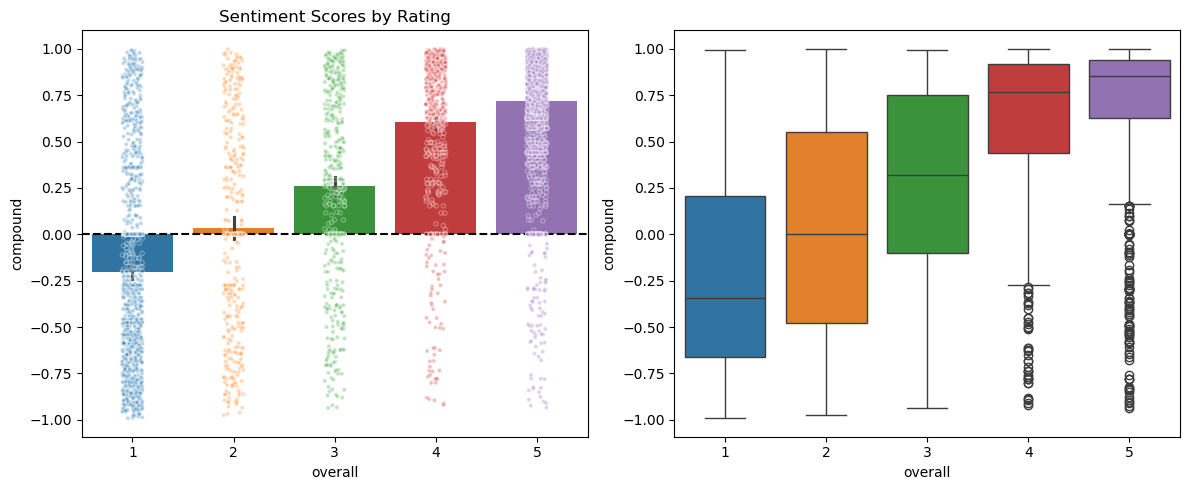

In [67]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
sns.barplot(data=df_sentiment, x='overall', y='compound', hue='overall', palette=palette_tab10,ax=axes[0], 
              legend=False)
sns.stripplot(data=df_sentiment, x='overall', y='compound', hue='overall', palette=palette_tab10,ax=axes[0], 
              legend=False,alpha=0.3, edgecolor='white', linewidth=1, size=3)
axes[0].set_title("Sentiment Scores by Rating")
axes[0].axhline(0, color='black', linestyle='--')
sns.boxplot(data=df_sentiment, x='overall', y='compound', hue='overall', palette=palette_tab10, ax=axes[1], legend=False)
fig.tight_layout()

<Axes: >

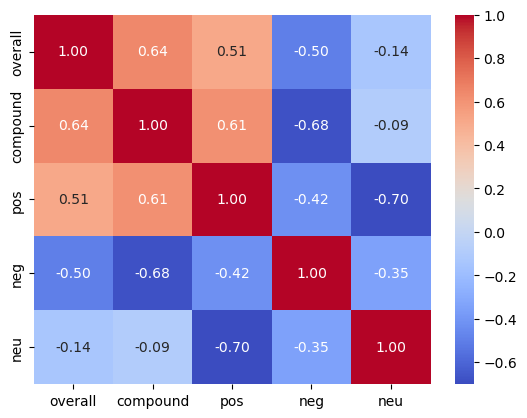

In [68]:
sentment_cols = ['compound','pos','neg','neu']
sns.heatmap(df_sentiment[['overall',*sentment_cols]].corr(), cmap='coolwarm', annot=True, fmt=".2f")

<Axes: >

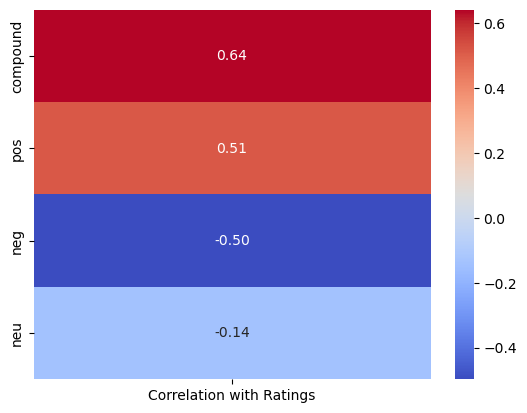

In [69]:
sns.heatmap(df_sentiment[sentment_cols].corrwith(df_sentiment['overall']).to_frame('Correlation with Ratings'),
            cmap='coolwarm', annot=True, fmt=".2f")

> To Do: Add Plotting Sentiment Scores

In [72]:
# raise Exception("stop here")

## Sentiment - HuggingFace Pipelines

In [73]:
# !pip install transformers

In [74]:
# # conda install tensorflow-mac tensorflow-metal
# !pip install tensorflow-macos#"<=2.13.1"
# !pip install tensorflow-metal

In [75]:
import tensorflow as tf

In [77]:
# dir(google)

In [78]:
# !pip install tensorflow-macos
# !pip install tensorflow-metal
# !pip install -U protobuf #==3.19.4
# # !pip install tf-keras

In [79]:
# !pip install -U torch torchvision torchaudio
# !pip install transformers

In [80]:
import tensorflow as tf


In [81]:
from transformers import pipeline
model = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_analyzer = pipeline(task="sentiment-analysis",model=model)

RuntimeError: Failed to import transformers.models.distilbert.modeling_tf_distilbert because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

In [ ]:
sentiment_analyzer("I think i enjoy it when I am being beat up")

: 

In [ ]:
df['review-text-full'].isna().sum()

: 

In [ ]:
test_text = df.loc[0,'review-text-full']
test_text

: 

In [ ]:
sentiment_analyzer(test_text)

: 

In [ ]:
sentiment_results = []
for i in df.index:
    text = df.loc[i, 'review-text-full']
    try:
        sent = sentiment_analyzer(text)[0]
        
    except Exception as e:
        display(e)
        sent = {'label':pd.NA,'score':pd.NA}
    finally:
        sentiment_results.append(sent)
        

# sentiment_results = df['review-text-full'].map(lambda x: sentiment_analyzer(x))
len(sentiment_results)

: 

In [ ]:
pd.DataFrame(sentiment_results)

: 

: 